<a href="https://colab.research.google.com/github/WanjohiWanjohi/Time_series_sales_predictor/blob/master/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [25]:
items = pd.read_csv('items.csv')
item_cats  =  pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
sales = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [27]:
from datetime import datetime
sales['year'] = pd.to_datetime(sales['date']).dt.strftime('%Y')
sales['month'] = sales.date.apply(lambda x: datetime.strptime(x,'%d.%m.%Y').strftime('%m')) #another way for same thing

sales.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.0,1.0,2013,01
1,03.01.2013,0,25,2552,899.0,1.0,2013,01


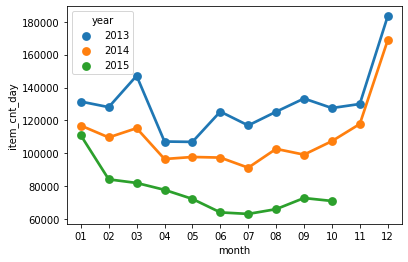

In [28]:
grouped = pd.DataFrame(sales.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=grouped)

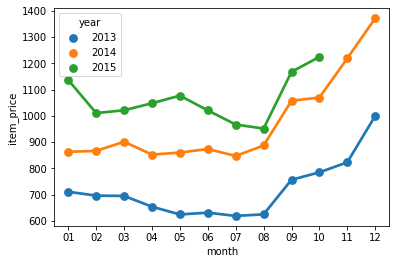

In [29]:
grouped_price = pd.DataFrame(sales.groupby(['year','month'])['item_price'].mean().reset_index())
sns.pointplot(x='month', y='item_price', hue='year', data=grouped_price)

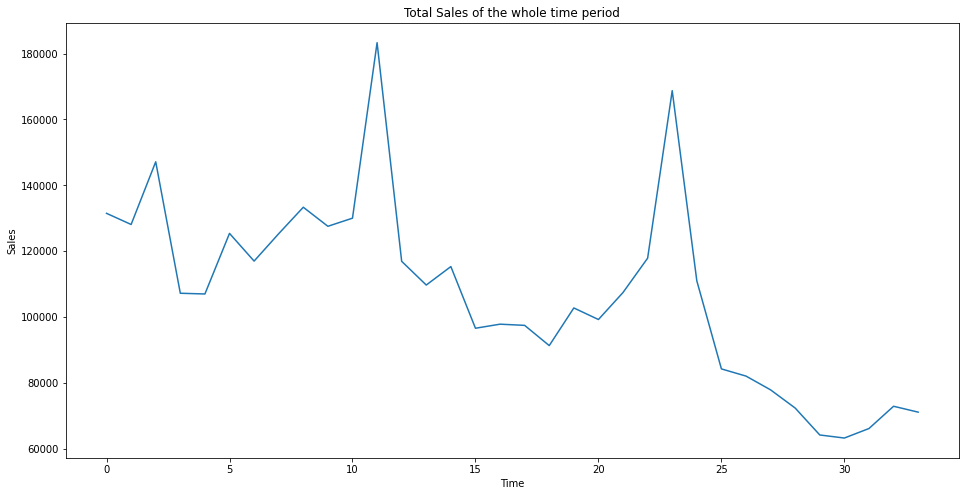

In [30]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the whole time period')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

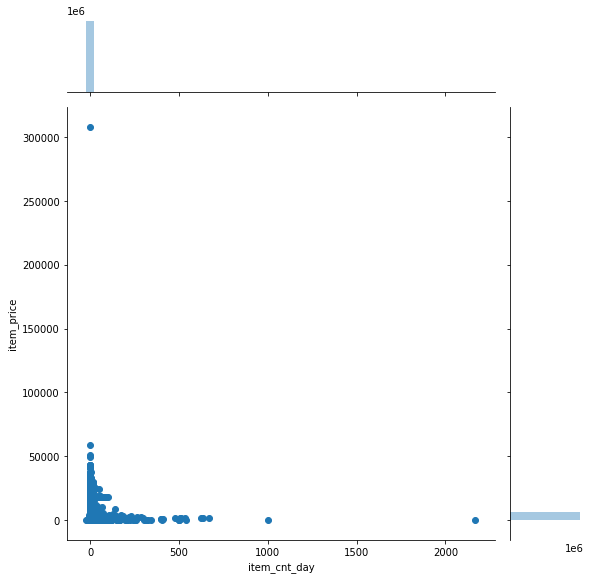

In [31]:
sns.jointplot(x="item_cnt_day", y="item_price", data=sales, height=8)
plt.show()

In [32]:
print('Data set size before remove item price 0 cleaning:', sales.shape)
sales = sales.query('item_price > 0')
print('Data set size after remove item price 0 cleaning:', sales.shape)

Data set size before remove item price 0 cleaning: (2935849, 8)
Data set size after remove item price 0 cleaning: (2935848, 8)


In [33]:
print('Data set size before filter valid:', sales.shape)
# Only shops that exist in test set.
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]
# Only items that exist in test set.
sales = sales[sales['item_id'].isin(test['item_id'].unique())]
print('Data set size after filter valid:', sales.shape)

Data set size before filter valid: (2935848, 8)
Data set size after filter valid: (1224439, 8)


In [34]:
print('Data set size before remove outliers:', sales.shape)
sales = sales.query('item_cnt_day >= 0 and item_cnt_day <= 125 and item_price < 75000')
print('Data set size after remove outliers:', sales.shape)

Data set size before remove outliers: (1224439, 8)
Data set size after remove outliers: (1221451, 8)


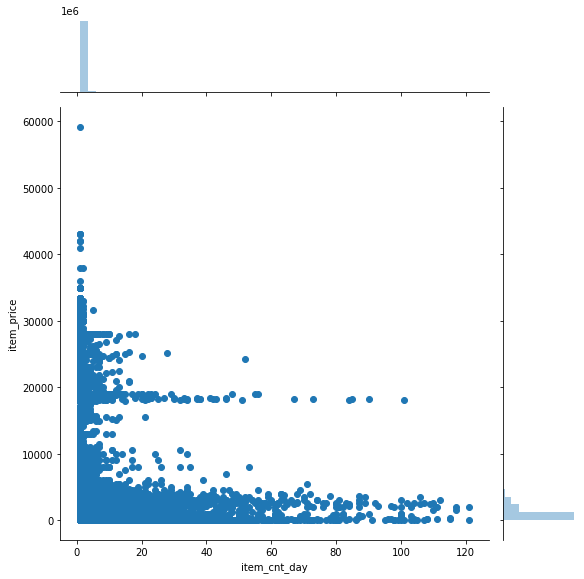

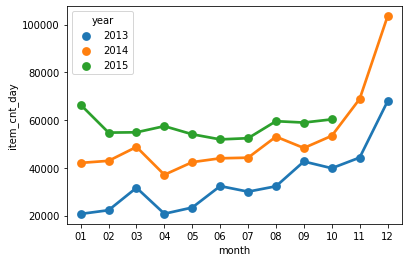

In [35]:
#After cleaning plot
sns.jointplot(x="item_cnt_day", y="item_price", data=sales, height=8)
plt.show()

cleaned = pd.DataFrame(sales.groupby(['year','month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='month', y='item_cnt_day', hue='year', data=cleaned)

In [36]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date_block_num","date","item_price","item_cnt_day"].agg({"date_block_num":'mean',"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


date_block_num  ... item_cnt_day
                                         mean  ...          sum
date_block_num shop_id item_id                 ...             
0              2       33                   0  ...          1.0
                       482                  0  ...          1.0
                       491                  0  ...          1.0
                       839                  0  ...          1.0
                       1007                 0  ...          3.0

[5 rows x 5 columns]

In [37]:
sales_data_flat = monthly_sales.item_cnt_day.apply(list).reset_index()
#Keep only the test data of valid
sales_data_flat = pd.merge(test,sales_data_flat,on = ['item_id','shop_id'],how = 'left')
#fill na with 0
sales_data_flat.fillna(0,inplace = True)
sales_data_flat.drop(['shop_id','item_id'],inplace = True, axis = 1)
sales_data_flat.head(20)

,ID,date_block_num,sum
0,0,20.0,1.0
1,0,22.0,1.0
2,0,23.0,2.0
3,0,24.0,2.0
4,0,28.0,1.0
5,0,29.0,1.0
6,0,30.0,1.0
7,0,31.0,3.0
8,0,32.0,1.0
9,1,0.0,0.0


In [38]:
#We will create pivot table.
# Rows = each shop+item code
# Columns will be out time sequence
pivoted_sales = sales_data_flat.pivot_table(index='ID', columns='date_block_num',fill_value = 0,aggfunc='sum' )
pivoted_sales.head(20)

sum                           ...                              
date_block_num 0.0  1.0  2.0  3.0  4.0  5.0   ... 28.0 29.0 30.0 31.0 32.0 33.0
ID                                            ...                              
0                 0    0    0    0    0    0  ...    1    1    1    3    1    0
1                 0    0    0    0    0    0  ...    0    0    0    0    0    0
2                 0    0    0    0    0    0  ...    3    2    0    1    3    1
3                 0    0    0    0    0    0  ...    0    0    0    1    0    0
4                 0    0    0    0    0    0  ...    0    0    0    0    0    0
5                 0    0    0    0    0    0  ...    3    0    0    0    1    1
6                 0    0    0    0    0    0  ...    0    0    0    0    3    2
7                 0    0    0    0    0    0  ...    0    1    0    0    0    0
8                 0    0    0    0    0    0  ...    2    4    3    2    3    0
9                 0    0    0    0    0    0  ...    0    0    0    0    0    0
10                0    0    0    0    0    0  ...    6    6    5    5    2    3
11                0    0    0    0    0    0  ...    0    0    0    0    1    0
12                0    0    1    0    1    0  ...    0    0    0    0    0    0
13                0    0    0    0    0    0  ...    0    3    1    1    0    0
14                0    0    0    0    0    0  ...    1    1    4    3    2    2
15                0    0    0    0    0    0  ...    6    1    1    2    1    6
16                0    0    0    0    0    0  ...    0    0    0    0    0    0
17                0    0    0    0    0    0  ...    0    1    0    0    0    0
18                0    0    0    0    0    0  ...    5    3    2    2    2    2
19                0    0    0    0    0    0  ...    0    0    0    0    0    0

[20 rows x 34 columns]

In [39]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(pivoted_sales.values[:,:-1],axis = 2)
# the last column is our prediction
y_train = pivoted_sales.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(pivoted_sales.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [40]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.models import load_model, Model

# our defining sales model 
sales_model = Sequential()
sales_model.add(LSTM(units = 64,input_shape = (33,1)))
#sales_model.add(LSTM(units = 64,activation='relu'))
sales_model.add(Dropout(0.5))
sales_model.add(Dense(1))

sales_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
sales_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [41]:
sales_model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 34s 647ms/step - loss: 5.7478 - mean_squared_error: 5.7478
Epoch 2/10
53/53 [==============================] - 34s 634ms/step - loss: 5.4934 - mean_squared_error: 5.4934
Epoch 3/10
53/53 [==============================] - 34s 639ms/step - loss: 5.3425 - mean_squared_error: 5.3425
Epoch 4/10
53/53 [==============================] - 34s 638ms/step - loss: 5.2563 - mean_squared_error: 5.2563
Epoch 5/10
53/53 [==============================] - 36s 670ms/step - loss: 5.1770 - mean_squared_error: 5.1770
Epoch 6/10
53/53 [==============================] - 34s 644ms/step - loss: 5.1297 - mean_squared_error: 5.1297
Epoch 7/10
53/53 [==============================] - 34s 639ms/step - loss: 5.0716 - mean_squared_error: 5.0716
Epoch 8/10
53/53 [==============================] - 34s 635ms/step - loss: 5.0702 - mean_squared_error: 5.0702
Epoch 9/10
53/53 [==============================] - 34s 644ms/step - loss: 4.9804 - mean_squared_error: 4.9804
E

In [42]:
submission_output = sales_model.predict(X_test)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_output.ravel()})
# creating csv file from dataframe
#submission.to_csv('submission.csv',index = False)
submission.to_csv('submission_stacked.csv',index = False)
submission.head()

,ID,item_cnt_month
0,0,0.442118
1,1,0.121668
2,2,0.750103
3,3,0.162697
4,4,0.121668
